### Required Packages

In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

### Reading Dataset

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency_K_pop_numeric,Frequency_Latin_numeric,Frequency_Lofi_numeric,Frequency_Metal_numeric,Frequency_Pop_numeric,Frequency_R&B_numeric,Frequency_Rap_numeric,Frequency_Rock_numeric,Frequency_Video_game_music_numeric,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,3,3,1,0,3,2,3,0,2,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,1,2,1,0,2,2,1,3,1,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,3,0,2,2,1,0,1,1,3,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,2,3,2,0,2,2,0,0,0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,3,2,2,0,2,3,3,0,1,10


### Question 1: What is the relationship between the variety of genres an individual listens to and their self-reported mental health conditions?

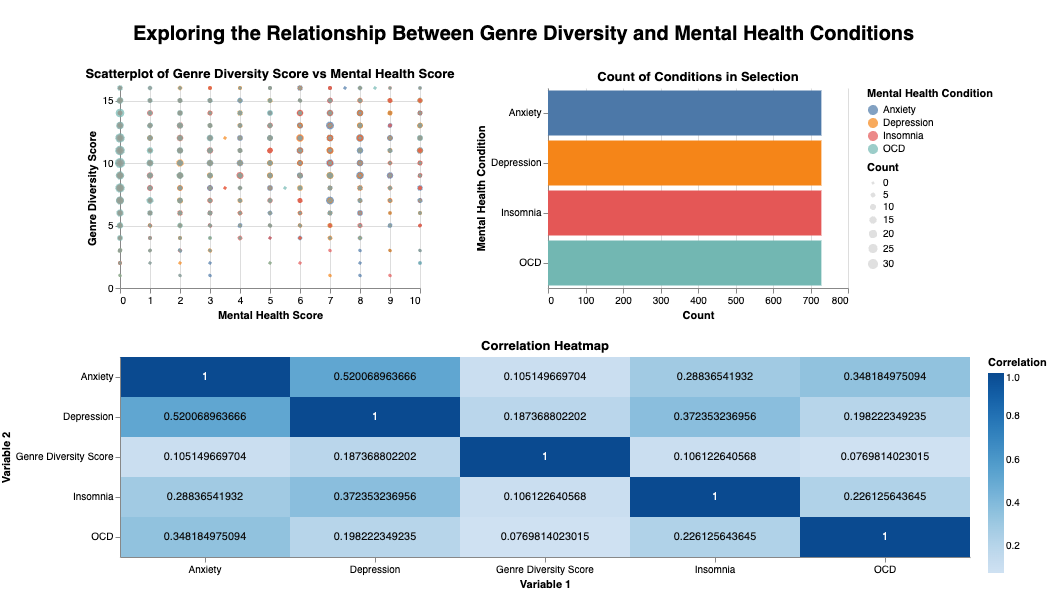

In [3]:
# melt the dataset to long format
data_long = mxmh.melt(id_vars=["Genre Diversity Score"], 
                       value_vars=["Anxiety", "Depression", "Insomnia", "OCD"],
                       var_name="Mental Health Condition", value_name="Mental Health Score")

brush = alt.selection_interval()

#  create scatterplot with brushing
points = alt.Chart(data_long).mark_circle(opacity=0.7).encode(
    x='Mental Health Score:Q',
    y='Genre Diversity Score:Q',
    color=alt.condition(brush, 'Mental Health Condition:N', alt.value("lightgray")),
    # shape='Mental Health Condition:N', 
    size=alt.Size('count():Q', scale=alt.Scale(range=[10, 100]), legend=alt.Legend(title="Count", orient="right")), 
    tooltip=['Mental Health Condition:N', 'Mental Health Score:Q', 'Genre Diversity Score:Q']
).add_params(brush).properties(
    title="Scatterplot of Genre Diversity Score vs Mental Health Score", width=300, height=200
)

# create bar chart
condition_counts = alt.Chart(data_long).mark_bar().encode(
    y=alt.Y('Mental Health Condition:N', title="Mental Health Condition"),
    x=alt.X('count():Q', title="Count"),
    color='Mental Health Condition:N',
    tooltip=['Mental Health Condition', 'count()']
).transform_filter(
    brush  
).properties(
    width=300, height=200, title="Count of Conditions in Selection"
)

# compute correlation matrix
correlation_matrix = mxmh[['Genre Diversity Score', 'Anxiety', 'Depression', 'Insomnia', 'OCD']].corr().reset_index().melt(id_vars='index')
correlation_matrix.columns = ['Variable 1', 'Variable 2', 'Correlation']

heatmap_selection = alt.selection_point(fields=['Variable 1'], bind='legend') 
points = points.transform_filter(heatmap_selection)
condition_counts = condition_counts.transform_filter(heatmap_selection)
 

correlation_chart = alt.Chart(correlation_matrix).mark_rect().encode(
    x=alt.X('Variable 1:N',axis=alt.Axis(labelAngle=0)),
    y='Variable 2:N',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='blues'), title="Correlation"),
    
).add_params(heatmap_selection).properties(
    width=850, height=200, title="Correlation Heatmap"
)
# Add correlation values as text labels
correlation_text = alt.Chart(correlation_matrix).mark_text(baseline='middle').encode(
    x=alt.X('Variable 1:N', axis=alt.Axis(labelAngle=0)),
    y='Variable 2:N',
    text='Correlation:Q',  
    color=alt.condition(
        alt.datum.Correlation == 1,  
        alt.value('#fefefe'),
        alt.value('#0a0a0a')  
    )
)

# Combine the heatmap and the text labels
correlation_chart_with_text = correlation_chart + correlation_text

chart_1 = alt.vconcat(
    alt.hconcat(points, condition_counts),
    correlation_chart_with_text
).properties(
    title={
        "text": "Exploring the Relationship Between Genre Diversity and Mental Health Conditions", 
        "fontSize": 20, 
        "fontWeight": "bold",
        "anchor": "middle", 
        "dy": -20  
    },
    padding={"top": 24, "bottom": 24}  
).resolve_scale(
    color='independent'
).resolve_legend(
    size='independent'  
).configure_view(
    stroke=None
)
chart_1

### Question 2: What is the distribution of genre diversity scores among individuals who report different effects of music on their well-being?

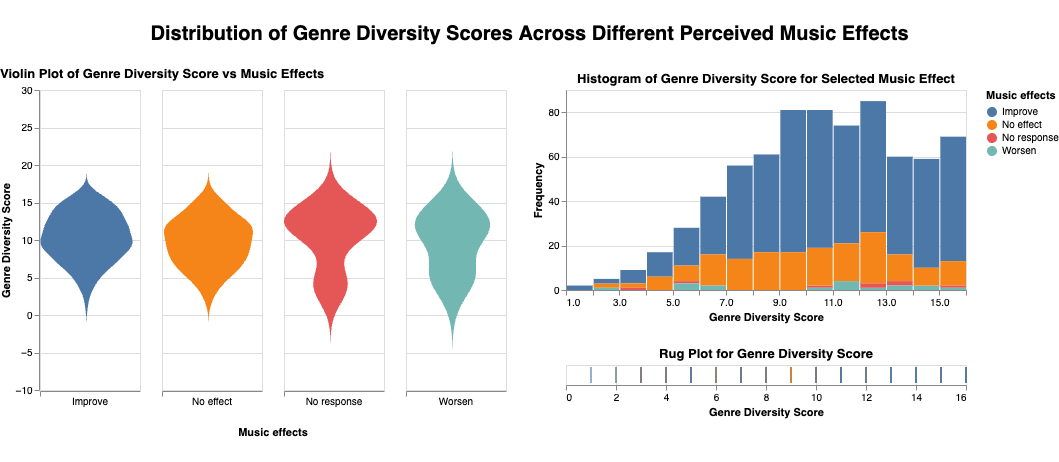

In [4]:
import altair as alt

# create interactive legend
interactive_legend = alt.selection_point(
    fields=['Music effects'],  
    bind='legend'
)

# create range slider
range_slider = alt.selection_interval(
    encodings=['y'],  
    bind='scales', 
    name='RangeSlider'
)

# create violin plot
violin = alt.Chart(mxmh).transform_filter(
    range_slider  
).transform_density(
    'Genre Diversity Score',
    as_=['Genre Diversity Score', 'density'],
    extent=[-5, 25],  
    groupby=['Music effects']
).transform_window(
    min_range='min(Genre Diversity Score)',  
    max_range='max(Genre Diversity Score)',  
    groupby=['Music effects']
).mark_area(orient='horizontal').encode(
    y=alt.Y('Genre Diversity Score:Q', title="Genre Diversity Score"),
    color=alt.Color('Music effects:N', scale=alt.Scale(scheme="tableau10")),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
    ),
    column=alt.Column(
        'Music effects:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    ),
    tooltip=[
        alt.Tooltip('max_range:Q', title="Genre Diversity Score") 
    ],
    opacity=alt.condition(interactive_legend, alt.value(1), alt.value(0.1))
).add_params(
    interactive_legend,
    range_slider
).properties(
    title='Violin Plot of Genre Diversity Score vs Music Effects',
    width=100
)

# create histogram
histogram = alt.Chart(mxmh).transform_filter(
    range_slider  
).transform_filter(
    interactive_legend  
).mark_bar().encode(
    x=alt.X('Genre Diversity Score:Q', bin=alt.BinParams(maxbins=20), title="Genre Diversity Score"),
    y=alt.Y('count()', title='Frequency'),
    color='Music effects:N'
).properties(
    title="Histogram of Genre Diversity Score for Selected Music Effect",
    width=400,
    height=200
)

# create rug plot 
rug_plot = alt.Chart(mxmh).transform_filter(
    range_slider  
).transform_filter(
    interactive_legend  
).mark_tick().encode(
    x='Genre Diversity Score:Q',
    color='Music effects:N'
).properties(
    title="Rug Plot for Genre Diversity Score", width=400
)


chart_2 = alt.hconcat(
    violin,  
    (histogram &  
    rug_plot)
).properties(
     title={
        "text": "Distribution of Genre Diversity Scores Across Different Perceived Music Effects", 
        "fontSize": 20, 
        "fontWeight": "bold",
        "anchor": "middle", 
        "dy": -20  
    },
    padding={"top": 24, "bottom": 24}  
).configure_concat(
    spacing=24,
)
chart_2


### Question 3: How does the frequency of listening to different music genres and genre preferences relate to self-reported mental health conditions and the perceived effects of music?

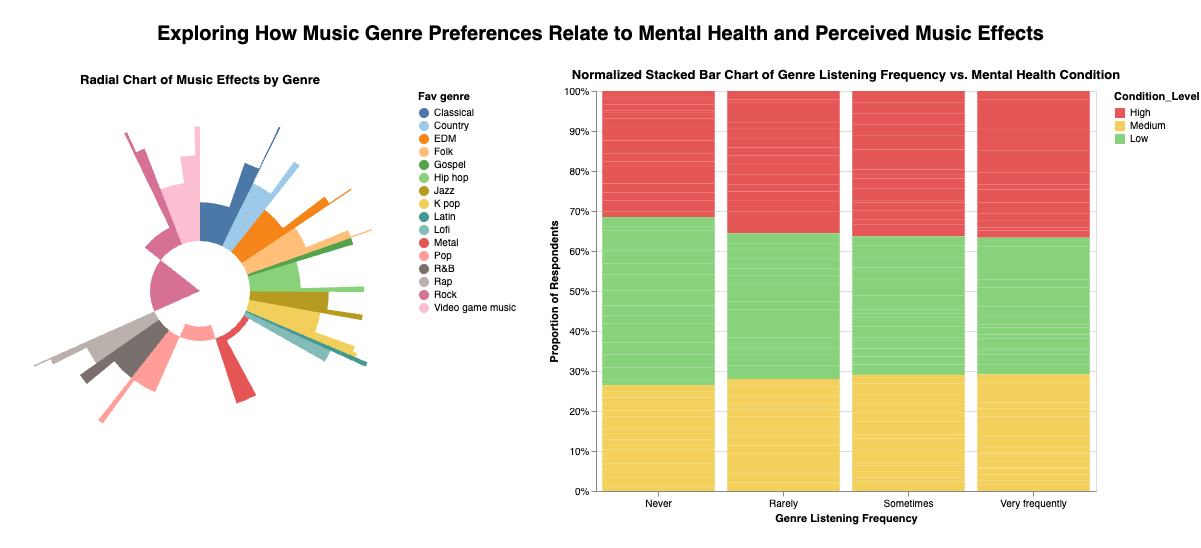

In [5]:
# melt the dataframe to have a single 'Frequency' column and a 'Fav Genre' column
genre_columns = [
    'Frequency_Classical',
       'Frequency_Country', 'Frequency_EDM', 'Frequency_Folk',
       'Frequency_Gospel', 'Frequency_Hip_hop', 'Frequency_Jazz',
       'Frequency_K_pop', 'Frequency_Latin', 'Frequency_Lofi',
       'Frequency_Metal', 'Frequency_Pop', 'Frequency_R&B', 'Frequency_Rap',
       'Frequency_Rock', 'Frequency_Video_game_music'
]

# define the mental health conditions 
mental_health_conditions = ['Anxiety_Level', 'Depression_Level','Insomnia_Level', 'OCD_Level',]

# create a dropdown filter for selecting mental health conditions
mental_health_dropdown = alt.binding_select(options=mental_health_conditions, name="Select Mental Health Condition: ")
mental_health_selection = alt.param(name="MentalHealthSelection", bind=mental_health_dropdown, value="Depression_Level")

# melt data based on the selected mental health condition
melted_data = mxmh.melt(id_vars=mental_health_conditions, value_vars=genre_columns,
                        var_name="Fav genre", value_name="Frequency")

melted_data['Fav genre'] = melted_data['Fav genre'].str.replace('Frequency_', '', regex=False).str.replace('_', ' ')

# restructure data to allow filtering by different conditions
melted_data = melted_data.melt(id_vars=["Fav genre", "Frequency"], value_vars=mental_health_conditions,
                               var_name="Mental_Health_Condition", value_name="Condition_Level")

# group data for stacked bar chart
data_grouped_bar = melted_data.groupby(['Fav genre', 'Frequency', 'Mental_Health_Condition', 'Condition_Level'], observed=False).size().reset_index(name='Count')

# compute proportions
group_sums = data_grouped_bar.groupby('Fav genre')['Count'].transform('sum')
data_grouped_bar['Proportion'] = data_grouped_bar['Count'] / group_sums

# selection for genre filtering
genre_selection = alt.selection_point(fields=["Fav genre"], name="GenreSelection", empty='all')

# selection for condition level filtering
condition_selection = alt.selection_point(fields=["Condition_Level"], name="ConditionSelection", empty='all')

# create stacked bar chart
stacked_bar_chart = alt.Chart(data_grouped_bar).mark_bar().encode(
    x=alt.X('Frequency:N', title="Genre Listening Frequency", axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Proportion:Q', title="Proportion of Respondents", stack='normalize', sort=['Low', 'Medium', 'High']),
    color=alt.Color('Condition_Level:N', scale=alt.Scale(domain=['High', 'Medium', 'Low'], range=['#E45756', '#F2D05B', '#88D27B'])), 
    tooltip=['Fav genre:N', 'Frequency:N', 'Mental_Health_Condition:N', 'Condition_Level:N', alt.Tooltip('Proportion:Q', format='.2%')],
    opacity=alt.condition(condition_selection, alt.value(1), alt.value(0.2))
).transform_filter(
    genre_selection
).transform_filter(
    (alt.datum["Mental_Health_Condition"] == mental_health_selection) 
).add_params(
    mental_health_selection, genre_selection, condition_selection
).properties(
    title="Normalized Stacked Bar Chart of Genre Listening Frequency vs. Mental Health Condition",
    width=500, height=400
)

# group data for radial chart
data_grouped_radial = mxmh.groupby(['Fav genre', 'Music effects']).size().reset_index(name='Count')
data_grouped_radial['Proportion'] = data_grouped_radial['Count'] / data_grouped_radial['Count'].sum()

# define options for music effects
music_effects_options = list(data_grouped_radial["Music effects"].unique())
music_effects_options.insert(0, "All")  

# create dropdown filter
music_effect_dropdown = alt.binding_select(
    options=music_effects_options,
    name="Select Music Effect: "
)
music_effect_selection = alt.param(name="MusicEffectSelection", bind=music_effect_dropdown, value="All")

radial_chart = alt.Chart(data_grouped_radial).mark_arc(innerRadius=50).encode(
    theta=alt.Theta('Proportion:Q', stack=True),  
    radius=alt.Radius('Proportion:Q', scale=alt.Scale(type='sqrt', zero=True, rangeMin=200)),  
    color=alt.Color('Fav genre:N', scale=alt.Scale(scheme="tableau20")), 
    tooltip=['Fav genre:N',  
        'Count:Q', 
        alt.Tooltip('Proportion:Q', format='.2%')],
    opacity=alt.condition(genre_selection, alt.value(1), alt.value(0.2))
).transform_filter(
    (alt.datum["Music effects"] == music_effect_selection) | (music_effect_selection == "All")
).add_params(
    music_effect_selection, genre_selection
).properties(
    width=400, 
    height=400,  
    title="Radial Chart of Music Effects by Genre"  
)

chart_3 = alt.hconcat(
    radial_chart, stacked_bar_chart,
    spacing=30  
).properties(
     title={
        "text": "Exploring How Music Genre Preferences Relate to Mental Health and Perceived Music Effects", 
        "fontSize": 20, 
        "fontWeight": "bold",
        "anchor": "middle", 
        "dy": -20  
    },
    padding={"top": 24, "bottom": 24}  
).resolve_scale(
    color='independent'
)

chart_3